# Comparing Cython, Numpy and Numba for a PFR Distributed Model

## The model

....



## Class for the model data

In [118]:
import numpy as np
import dasslcy
from functools import partial
import numba #from numba import jit, jitclass
NPTS = 100
dyn_solver = partial(dasslcy.solve, share_res=1)
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [119]:
class pfr():
    def __init__(self, N = 20):
        self.D = 1.0
        self.vz = 1.0
        self.k = 1.0
        self.Cf = 1.0
        self.z0 = 0.0
        self.zf = 1.0
        self.N = N
        self.h = self.get_h()

    def get_h(self):
        return (self.zf - self.z0) / self.N
    
def solver_setup_base(N):
    par = pfr(N)
    t0 = np.array([5.0])
    y0 = np.zeros(par.N)
    yp0 = None
    atol = 1e-8
    rtol = 1e-6
    return [t0, y0, yp0, par, rtol, atol]

## Pure Python

Setting dynamic model and solving

In [120]:
def model_pfr(t, y, yp, par, res):
    N = par.N
    D, vz, k, Cf, h = par.D, par.vz, par.k, par.Cf, par.h
    dCi = yp
    Ci = y
    aux1 = D / (vz * h)
    C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
    CNp1 = Ci[N - 1]
    aux2 = D / h**2
    aux3 = vz / (2 * h)
    res[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
        aux3 * (Ci[1] - C0) + k * Ci[0] - dCi[0]
    for i in np.arange(1, N - 1):
        tt1 = aux2 * (Ci[i + 1] - 2.0 * Ci[i] + Ci[i - 1])
        tt2 = -aux3 * (Ci[i + 1] - Ci[i - 1]) + k * Ci[i]
        res[i] = tt1 + tt2 - dCi[i]
    res[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
        aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1] - dCi[N - 1]
    return res, 0

In [142]:
base_args = solver_setup_base(NPTS)
o = %timeit -r 10 -n 1 -o dyn_solver(model_pfr, *base_args) 

411 ms ± 164 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [152]:
o.all_runs

[0.004366614424725412,
 0.0042389065874886,
 0.004178413400950376,
 0.004298230822314508,
 0.00432920800994907,
 0.004573226417051046,
 0.004241536724293837,
 0.0048523133373237215,
 0.004885336189545342,
 0.005547546621528454]

## Numpy broadcasting

In [143]:
def model_pfr_np(t, y, yp, par, res):
    N = par.N
    D, vz, k, Cf, h = par.D, par.vz, par.k, par.Cf, par.h
    dCi = yp
    Ci = y
    aux1 = D / (vz * h)
    C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
    CNp1 = Ci[N - 1]
    aux2 = D / h**2
    aux3 = vz / (2 * h)
    res[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
        aux3 * (Ci[1] - C0) + k * Ci[0] - dCi[0]
    tt1 = aux2 * (Ci[2:] - 2.0 * Ci[1:-1] + Ci[0:-2])
    tt2 = -aux3 * (Ci[2:] - Ci[0:-2]) + k * Ci[1:-1]
    res[1:-1] = tt1 + tt2 - dCi[1:-1]

    res[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
        aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1] - dCi[N - 1]
    return res, 0

In [144]:
o = %timeit -r 10 -n 1 -o dyn_solver(model_pfr_np, *base_args)

28.7 ms ± 3.26 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Cython Naive implementation

In [146]:
%%cython
import numpy as np
cimport numpy as np
def model_pfr_cy(t, y, yp, par, res):
    N = par.N
    D, vz, k, Cf, h = par.D, par.vz, par.k, par.Cf, par.h
    dCi = yp
    Ci = y
    aux1 = D / (vz * h)
    C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
    CNp1 = Ci[N - 1]
    aux2 = D / h**2
    aux3 = vz / (2 * h)
    res[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
        aux3 * (Ci[1] - C0) + k * Ci[0] - dCi[0]
    for i in np.arange(1, N - 1):
        tt1 = aux2 * (Ci[i + 1] - 2.0 * Ci[i] + Ci[i - 1])
        tt2 = -aux3 * (Ci[i + 1] - Ci[i - 1]) + k * Ci[i]
        res[i] = tt1 + tt2 - dCi[i]
    res[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
        aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1] - dCi[N - 1]
    return res, 0

In [147]:
o = %timeit -r 10 -n 1 -o dyn_solver(model_pfr_cy, *base_args)

334 ms ± 8.38 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Cython Typed Implementation

In [224]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython 

#cython: boundscheck=False
#cython: wraparound=False

cdef class Pfr_Cython:
    cdef:
        double D, vz, k, Cf, z0, zf, h
        int N
    def __init__(self, N = 20):
        self.N = N
        self.D = 1.0
        self.vz = 1.0
        self.k = 1.0
        self.Cf = 1.0
        self.z0 = 0.0
        self.zf = 1.0
        self.h = self.get_h()
    cdef get_h(self):
        return (self.zf - self.z0) / self.N
    
    @cython.boundscheck(False)  # Deactivate bounds checking
    @cython.wraparound(False)   # Deactivate negative indexing.
    cdef cythonized_base_model_calculations(self, np.float64_t[:] res, np.float64_t[:] y, np.float64_t[:] yp,
        int N, double D, double vz, double k, double Cf, double h):
        cdef:
            int i
            double tt1, tt2
        cdef np.float64_t[:] dCi = yp
        cdef np.float64_t[:] Ci = y
        cdef double aux1 = D / (vz * h)
        cdef double C0 = 1.0 / (1.0 + aux1) * (aux1 * Ci[0] + Cf)
        cdef double CNp1 = Ci[N - 1]
        cdef double aux2 = D / h**2
        cdef double aux3 = vz / (2 * h)
        res[0] = aux2 * (Ci[1] - 2.0 * Ci[0] + C0) - \
            aux3 * (Ci[1] - C0) + k * Ci[0] - dCi[0]
        for i in range(1, N - 1):
            tt1 = aux2 * (Ci[i + 1] - 2.0 * Ci[i] + Ci[i - 1])
            tt2 = -aux3 * (Ci[i + 1] - Ci[i - 1]) + k * Ci[i]
            res[i] = tt1 + tt2 - dCi[i]
        res[N - 1] = aux2 * (CNp1 - 2.0 * Ci[N - 1] + Ci[N - 2]) - \
            aux3 * (CNp1 - Ci[N - 2]) + k * Ci[N - 1] - dCi[N - 1]
        pass
    
    @cython.boundscheck(False)  # Deactivate bounds checking
    @cython.wraparound(False)   # Deactivate negative indexing.    
    cpdef cython_model(self, double t, np.float64_t[:] y, np.float64_t[:] yp, np.float64_t[:] res):
        self.cythonized_base_model_calculations(
                res, y, yp, self.N, self.D, self.vz, self.k, self.Cf, self.h)
        return res, 0

In [225]:
#initialize_cy_pfr_model(NPTS)
pr_Cy = Pfr_Cython(NPTS)
cy_args = solver_setup_base(NPTS)
cy_args[3] = None
o = %timeit -r 10 -n 1 -o dyn_solver(pr_Cy.cython_model, *cy_args)

16.6 ms ± 6.17 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## Numba

- Create a function closure to define numba scoped variables

In [166]:
spec = [
    ('N', numba.int32),
    ('D', numba.float64),
    ('vz', numba.float64),
    ('k', numba.float64),
    ('Cf', numba.float64),
    ('z0', numba.float64),
    ('zf', numba.float64),
    ('h', numba.float64),
]
Numba_PFR = numba.jitclass(spec)(pfr)
jitted_pfr_model = numba.jit(model_pfr, nopython=True)
numba_pfr = Numba_PFR(NPTS)
numba_args = solver_setup_base(NPTS)
numba_args[3] = numba_pfr
dyn_solver(jitted_pfr_model, *numba_args);

In [226]:
o = %timeit -r 10 -n 1 -o dyn_solver(jitted_pfr_model, *numba_args)

4.38 ms ± 116 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [228]:
numba_pfr.N = 100

## Performance for discretization point 

In [229]:
import perfplot
def run_py(N):
    base_args = solver_setup_base(N)
    dyn_solver(model_pfr, *base_args)
    return 0
# def run_py(N):
#     #return N*2
#     N*2
#     return 0
def run_np(N):
    base_args = solver_setup_base(N)
    dyn_solver(model_pfr_np, *base_args)
    return 0
def run_cy_naive(N):
    base_args = solver_setup_base(N)
    dyn_solver(model_pfr_cy, *base_args)
    return 0
def run_cy_typed(N):
    pr_Cy = Pfr_Cython(N)
    cy_args = solver_setup_base(N)
    cy_args[3] = None    
    dyn_solver(pr_Cy.cython_model, *cy_args)
    return 0
def run_numba(N):
    numba_pfr = Numba_PFR(N)
    numba_args = solver_setup_base(N)
    numba_args[3] = numba_pfr
    dyn_solver(jitted_pfr_model, *numba_args)
    return 0

# Setup as array ?
# All return None -> failing

100%|███████████████████████████████████████████| 9/9 [00:47<00:00,  5.33s/it]


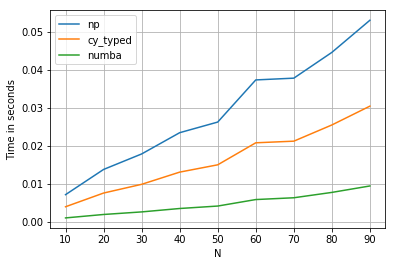

In [233]:
perfplot.show(
    setup=lambda N: N,
    kernels=[
        #run_py,
        run_np,
        #run_cy_naive,
        run_cy_typed,
        run_numba
        ],
    #labels=['py', 'np', 'cy_naive', 'cy_typed', 'numba'],
    labels=['np', 'cy_typed', 'numba'],
    n_range=[10*k for k in range(1, 10)], #n_range=[2**k for k in range(2)],
    xlabel='N'
    )

array([0.48345709, 0.9917766 ])